# 线性模型

## 回归

### 生成数据集

为了简单起见，我们将[**根据带有噪声的线性模型构造一个人造数据集。**]
我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。
我们将使用低维数据，这样可以很容易地将其可视化。
在下面的代码中，我们生成一个包含1000个样本的数据集，
每个样本包含从标准正态分布中采样的2个特征。
我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$

你可以将$\epsilon$视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。
下面的代码生成合成数据集。



In [1]:
import random
import torch
import matplotlib.pyplot as plt

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

[**`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）**]。

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.0139, 1.1652]) 
label: tensor([0.2676])


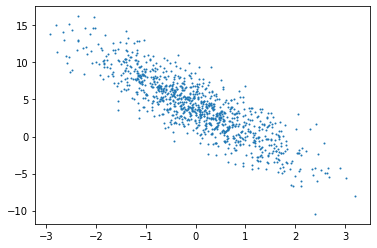

In [4]:
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据集

我们可以[**调用框架中现有的API来读取数据**]。
我们将`features`和`labels`作为API的参数传递，并通过数据迭代器指定`batch_size`。
此外，布尔值`is_train`表示是否希望数据迭代器对象在每个迭代周期内打乱数据。

In [5]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

读取第一个小批量数据样本并打印。 每个批量的特征维度显示批量大小和输入特征数。

In [6]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [7]:
for X, y in iter(data_iter):
    print(X, '\n', y)
    break

tensor([[-1.7109, -0.6625],
        [-1.1752,  1.7618],
        [ 0.1332, -1.1871],
        [ 1.7244, -1.1725],
        [-0.3222,  0.6679],
        [ 0.1291,  1.8241],
        [ 2.2547, -0.4121],
        [ 0.9001, -0.1948],
        [ 0.5214,  0.3068],
        [-1.8550, -2.4799]]) 
 tensor([[ 3.0296],
        [-4.1294],
        [ 8.5051],
        [11.6248],
        [ 1.2807],
        [-1.7514],
        [10.0975],
        [ 6.6660],
        [ 4.2070],
        [ 8.9113]])


### 定义模型

在PyTorch中，全连接层在`Linear`类中定义。
值得注意的是，我们将两个参数传递到`nn.Linear`中。
第一个指定输入特征形状，即2，第二个指定输出特征形状，输出特征形状为单个标量，因此为1。

In [8]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

### 初始化模型参数

In [9]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数

In [10]:
loss = nn.MSELoss()

### 定义优化算法

In [11]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 训练

对于每一个小批量，我们会进行以下步骤:

* 通过调用`net(X)`生成预测并计算损失`l`（前向传播）。
* 通过进行反向传播来计算梯度。
* 通过调用优化器来更新模型参数。

为了更好的衡量训练效果，我们计算每个迭代周期后的损失，并打印它来监控训练过程

In [12]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000272
epoch 2, loss 0.000106
epoch 3, loss 0.000107


**比较生成数据集的真实参数和通过有限数据训练获得的模型参数**。

In [13]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([0.0001, 0.0002])
b的估计误差： tensor([-0.0015])


## 分类

### 生成数据集

以图片分类问题为例，使用Fashion-MNIST数据集，并设置数据迭代器的批量大小为256

In [14]:
import torch
from IPython import display
from torchvision import transforms
import torchvision

In [16]:
batch_size = 256
trans = transforms.ToTensor() # 数据预处理，将PIL转换成张量
train_data = torchvision.datasets.FashionMNIST(root="./data", train=True,
                                                transform=trans,
                                                download=False)
test_data = torchvision.datasets.FashionMNIST(root="./data", train=False,
                                               transform=trans, download=False)

In [17]:
train_iter=torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_iter=torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

### 初始化模型及其参数

原始数据集中的每个样本都是$28 \times 28$的图像。
在本节中，我们[**将展平每个图像，把它们看作长度为784的向量。**]


本例中使用softmax 回归，其输出层是一个带有10个输出的全连接层
我们仍然以均值0和标准差0.01随机初始化权重。

In [18]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

### 损失函数

In [19]:
loss = nn.CrossEntropyLoss(reduction='none')

### 优化算法

在这里，我们(**使用学习率为0.1的小批量随机梯度下降作为优化算法**)。
这与我们在线性回归例子中的相同，这说明了优化器的普适性。



In [20]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

### 训练

这里定义一个实用程序类Accumulator，用于对多个变量进行累加。 在后面的训练函数中， 我们在(Accumulator实例中创建了3个变量， 分别用于存储训练损失总和、训练准确度总和、样本数)。 当我们遍历数据集时，两者都将随着时间的推移而累加。

In [21]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

定义accuracy函数来计算**一个batch**中预测正确的数量

In [26]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


定义evaluate函数计算模型在测试集上的预测精度

In [22]:
def evaluate(net, data_iter):  #@save
    """计算在测试集上模型的精度"""
    net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

 首先，我们定义一个函数来训练一个迭代周期

In [23]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    # 将模型设置为训练模式
    net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        # 使用PyTorch内置的优化器和损失函数
        updater.zero_grad()
        l.mean().backward()
        updater.step()
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

接下来我们实现一个**训练函数**， 它会在训练数据集上训练一个模型net。 该训练函数将会运行多个迭代周期（由num_epochs指定）。 在每个迭代周期结束时，利用测试数据集对模型进行评估。

In [24]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    t_loss=[]
    t_acc=[]
    for epoch in range(num_epochs):
        train_loss, train_acc= train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate(net, test_iter)
        t_loss.append(train_loss)
        t_acc.append(train_acc)
        
    return t_loss,t_acc 

In [27]:
num_epochs = 10
train_loss,test_acc =train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

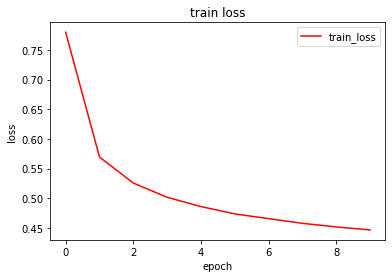

In [28]:
plt.plot(range(len(train_loss)), train_loss, 'r', label = 'train_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('train loss')
plt.legend() 

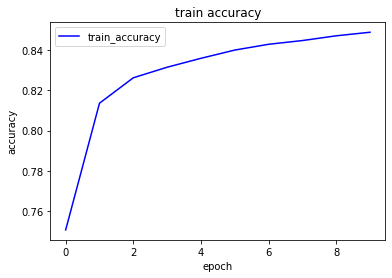

In [29]:
plt.plot(range(len(test_acc)), test_acc, 'b', label = 'train_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('train accuracy')
plt.legend() 

## 预测

现在训练已经完成，我们的模型已经准备好[**对图像进行分类预测**]。
给定一系列图像，我们将比较它们的实际标签（文本输出的第一行）和模型预测（文本输出的第二行）。

In [30]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [31]:
def show_images(images, labels):
    display.set_matplotlib_formats('svg')#用矢量图进行展示
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

/var/folders/0t/w0ff24cs6v76t0jn13gpq83w0000gn/T/ipykernel_40364/2757353694.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')#用矢量图进行展示


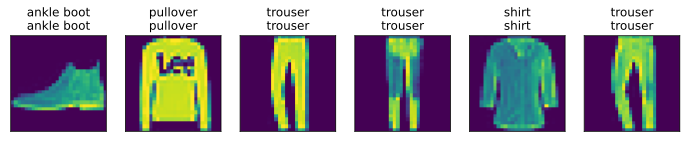

In [32]:
def predict_ch3(net, test_iter, n=6):  #@save
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), labels=titles[0:n])

predict_ch3(net, test_iter)

# RNN 循环神经网络

RNN适合处理时间序列相关的问题，本例中使用RNN用sin值预测cos值

![这是图片](./RNN.png "Magic Gardens")

* h_0 是我们初始的h_state就是None，然后当我们每次训练完，我们的一次数据后我们的h_state将会保存，然后输出，然后输出(将以前的记忆)到我们下一次训练数据的时候。
* 我们训练的不止是隐藏层的参数，还有我们的h_state(记忆)

In [33]:
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation
import math, random

### 定义超参数

In [34]:
TIME_STEP = 10 # rnn 时序步长数
INPUT_SIZE = 1 # rnn 的输入维度
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
H_SIZE = 64 # of rnn 隐藏单元个数
EPOCHS=300 # 总共训练次数
h_state = None # 隐藏层状态

### 生出并可视化数据集

生成训练所需的样本sin和标签cos

In [35]:
# 生成数据
steps = np.linspace(0, np.pi*2, 256, dtype=np.float32)
x_np = np.sin(steps) 
y_np = np.cos(steps)

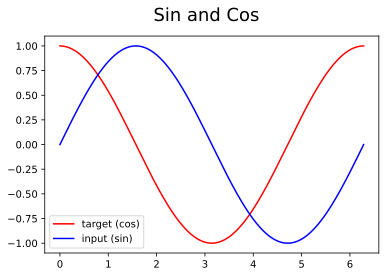

In [36]:
# 可视化数据
plt.figure(1)
plt.suptitle('Sin and Cos',fontsize='18')
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

### 搭建网络

In [37]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
        input_size=INPUT_SIZE,
        hidden_size=H_SIZE, 
        num_layers=1, 
        batch_first=True,
        )
        self.out = nn.Linear(H_SIZE, 1)
    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)
        outs = [] # 保存所有的预测值
        for time_step in range(r_out.size(1)): # 计算每一步长的预测值
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state
rnn = RNN().to(DEVICE)

### 定义损失函数和优化算法

In [38]:
optimizer = torch.optim.Adam(rnn.parameters()) # Adam优化，几乎不用调参
criterion = nn.MSELoss() # 因为最终的结果是一个数值，所以损失函数用均方误差

### 训练

训练并预测cos值，其中红色为用numpy生成的真实cos值，蓝色为用RNN预测的cos值

EPOCHS: 59,Loss:0.003311


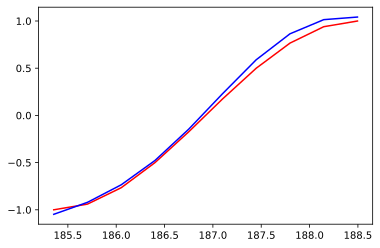

EPOCHS: 119,Loss:0.000764


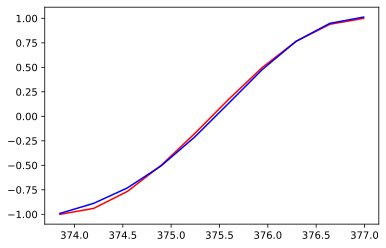

EPOCHS: 179,Loss:0.108843


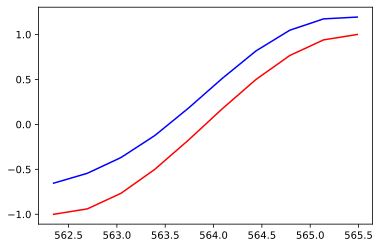

EPOCHS: 239,Loss:0.001459


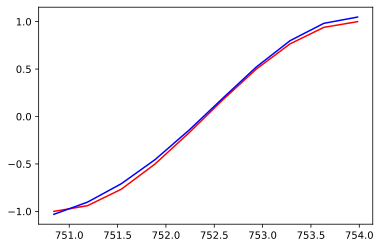

EPOCHS: 299,Loss:0.005812


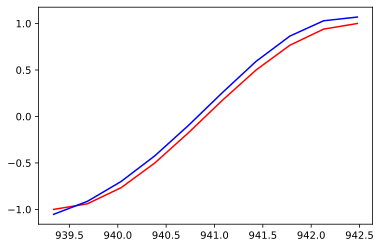

In [39]:
# 由于没有测试集，所以我们训练和测试写在一起了
rnn.train()
plt.figure(2)
for step in range(EPOCHS):
    start, end = step * np.pi, (step+1)*np.pi # 一个时间周期
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps) 
    y_np = np.cos(steps)
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis]) # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    prediction, h_state = rnn(x, h_state) # rnn output
    # 这一步非常重要
    h_state = h_state.data # 重置隐藏层的状态, 切断和前一次迭代的链接
    loss = criterion(prediction, y) 
    # 这三行写在一起就可以
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if (step+1)%60==0: #每训练20个批次可视化一下效果，并打印一下loss
        print("EPOCHS: {},Loss:{:4f}".format(step,loss))
        plt.plot(steps, y_np.flatten(), 'r-')
        plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
        plt.draw()
        plt.pause(0.01)

## CNN

本例使用卷积神经网络（CNN）模型，用于预测手写数字图片

![这是图片](./MNIST1.png)

In [41]:
#导入需要的包
import numpy as np
import torch 
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms,utils

MNIST数据集包含60000个训练集和10000测试数据集。分为图片和标签，图片是28*28的像素矩阵，标签为0~9共10个数字。

![这是图片](./MNIST2.png)

### 下载数据集MNIST

root为数据集存放的路径，transform指定数据集导入的时候需要进行的变换，train设置为true表明导入的是训练集合，否则会测试集合。
Compose是把多种数据处理的方法集合在一起。使用transforms进行Tensor格式转换和Normalization归一化。

In [42]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5],std=[0.5])])

In [43]:
train_data = datasets.MNIST(root = "./data/",transform=transform,train = True,download = True)

test_data = datasets.MNIST(root="./data/",transform = transform,train = False)

train_data 的个数：60000个训练样本

test_data 的个数：10000个训练样本

In [44]:
len(train_data),len(test_data)

(60000, 10000)

### 使用Dataloader加载数据

num_workers 表示用多少个子进程加载数据

shuffle 表示在装载过程中随机乱序

设置batch_size=64后，加载器中的基本单为是一个batch的数据

所以train_loader 的长度是60000/64 = 938 个batch

test_loader 的长度是10000/64= 157个batch

In [45]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,
                                          shuffle=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,
                                          shuffle=True,num_workers=2)

### 查看数据

输出一张图片

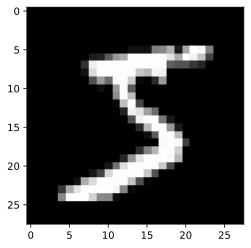

In [46]:
oneimg,label = train_data[0]
grid = utils.make_grid(oneimg)
grid = grid.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
grid = grid * std + mean
plt.imshow(grid)
plt.show()

输出一个Batch的图片和标签

tensor(6) tensor(0) tensor(1) tensor(7) tensor(4) tensor(8) tensor(4) tensor(3) 
tensor(4) tensor(3) tensor(8) tensor(6) tensor(6) tensor(5) tensor(5) tensor(7) 
tensor(9) tensor(9) tensor(9) tensor(5) tensor(2) tensor(2) tensor(4) tensor(5) 
tensor(8) tensor(9) tensor(1) tensor(1) tensor(0) tensor(0) tensor(4) tensor(6) 
tensor(5) tensor(7) tensor(5) tensor(8) tensor(8) tensor(6) tensor(3) tensor(9) 
tensor(6) tensor(0) tensor(5) tensor(9) tensor(4) tensor(5) tensor(7) tensor(9) 
tensor(0) tensor(1) tensor(8) tensor(3) tensor(8) tensor(7) tensor(0) tensor(2) 
tensor(5) tensor(0) tensor(9) tensor(3) tensor(6) tensor(3) tensor(8) tensor(1) 


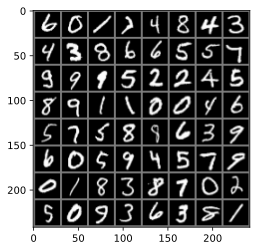

In [47]:
images, lables = next(iter(train_loader))
img = utils.make_grid(images)
# transpose 转置函数(x=0,y=1,z=2),新的x是原来的y轴大小，新的y是原来的z轴大小，新的z是原来的x大小
#相当于把x=1这个一道最后面去。
img = img.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
img = img * std + mean
for i in range(64):
    print(lables[i], end=" ")
    i += 1
    if i%8 == 0:
        print(end='\n')
plt.imshow(img)
plt.show()

### 搭建网络

![这是图片](./MNIST3.png)

In [48]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(64*7*7,1024)#两个池化，所以是7*7而不是14*14
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,10)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
             
        x = x.view(-1, 64 * 7* 7)#将数据平整为一维的 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))   
        x = self.fc3(x)  
        return x
        
net = CNN()        

###  损失函数与优化算法

In [49]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

### 训练

In [50]:
train_accs = []
train_loss = []
test_accs = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
for epoch in range(3):
    running_loss = 0.0
    for i,data in enumerate(train_loader,0):#0是下标起始位置默认为0
        inputs,labels = data[0].to(device), data[1].to(device)
        #初始为0，清除上个batch的梯度信息
        optimizer.zero_grad()         
        
        #前向+后向+优化     
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        # loss 的输出，每个一百个batch输出，平均的loss
        running_loss += loss.item()
        if i%100 == 99:
            print('[%d,%5d] loss :%.3f' %
                 (epoch+1,i+1,running_loss/100))
            running_loss = 0.0
        train_loss.append(loss.item())
        
        # 训练曲线的绘制 一个batch中的准确率
        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)# labels 的长度
        correct = (predicted == labels).sum().item() # 预测正确的数目
        train_accs.append(100*correct/total)
        
print('Finished Training')     


[1,  100] loss :2.293
[1,  200] loss :2.264
[1,  300] loss :2.207
[1,  400] loss :2.030
[1,  500] loss :1.470
[1,  600] loss :0.802
[1,  700] loss :0.566
[1,  800] loss :0.474
[1,  900] loss :0.396
[2,  100] loss :0.328
[2,  200] loss :0.323
[2,  300] loss :0.293
[2,  400] loss :0.259
[2,  500] loss :0.250
[2,  600] loss :0.231
[2,  700] loss :0.227
[2,  800] loss :0.214
[2,  900] loss :0.184
[3,  100] loss :0.190
[3,  200] loss :0.171
[3,  300] loss :0.159
[3,  400] loss :0.156
[3,  500] loss :0.144
[3,  600] loss :0.134
[3,  700] loss :0.124
[3,  800] loss :0.136
[3,  900] loss :0.122
Finished Training


查看loss和训练数据集上的准确率变化

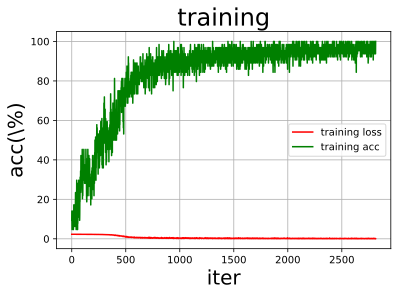

In [51]:
def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("acc(\%)", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()
train_iters = range(len(train_accs))
draw_train_process('training',train_iters,train_loss,train_accs,'training loss','training acc')

### 预测

查看测试集上整体的正确率

In [52]:
correct = 0
total = 0
with torch.no_grad():# 进行评测的时候网络不更新梯度
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)# labels 的长度
        correct += (predicted == labels).sum().item() # 预测正确的数目

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the  test images: 96 %


查看10个数字分别的正确率

In [53]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
#         print(predicted == labels)
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %d : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 99 %
Accuracy of 1 : 99 %
Accuracy of 2 : 96 %
Accuracy of 3 : 96 %
Accuracy of 4 : 96 %
Accuracy of 5 : 98 %
Accuracy of 6 : 96 %
Accuracy of 7 : 94 %
Accuracy of 8 : 96 %
Accuracy of 9 : 94 %


### 可视化预测结果
实际标签（文本输出的第一行）与模型预测（文本输出的第二行）

/var/folders/0t/w0ff24cs6v76t0jn13gpq83w0000gn/T/ipykernel_40364/2757353694.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')#用矢量图进行展示


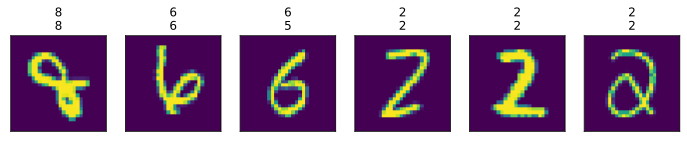

In [54]:
def get_mnist_labels(labels):
    text_labels = [str(i) for i in range(10)]
    return [text_labels[int(i)] for i in labels]

def predict_ch3(net, test_iter, n=6):  #@save
    for X, y in test_iter:
        break
    outputs = net(X)
    _, predicted = torch.max(outputs.data, 1)
    trues = get_mnist_labels(y)
    preds = get_mnist_labels(predicted)
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), labels=titles[0:n])

predict_ch3(net, test_loader)